# Introducción

Este Notebook compone la segunda e última entrega de la entrevista técnica para IA&Data en Capgemini. En esta parte de la evaluación se nos pide:

'Escoge un dataset abierto de series temporales multivariante que no sea financiero y donde la variable a predecir no tenga estacionalidad. Tienes que hacer un notebook donde se predigan 100 instantes de tiempo en el futuro con la particularidad que a partir del instante donde se inicia la predicción no se dispone de los valores de las variables regresoras.'


## Datos

Se ha elegido el conocido dataset [Beijing PM2.5](https://archive.ics.uci.edu/dataset/381/beijing+pm2+5+data), un conocido dataset horario que contiene los datos de [PM2.5](https://es.wikipedia.org/wiki/PM2.5) (**partículas contaminantes**) de la Embajada de EE.UU. en Pekín. También se incluyen datos meteorológicos del Aeropuerto Internacional de Pekín en esos momentos por lo que conforman un buen conjunto de datos multivariante. Las variables son:

- Year, Month, Day, hour: Variables temporales (se combinaran para formar el orden de serie temporal).
- pm2.5: La concentracion de partículas. Variable respuesta
- DEWP: El Dew Point (temperatura atmosférica por debajo de la cual las gotas de agua empiezan a condensarse)
- TEMP: Temperatura
- cbwd: Direccion del viento (Categórica)
- Iws: Velocidad del viento (m/s)
- Is: Nieve (horas)
- Ir: LLuvia (horas)

**Nota**: Como la mayoría de data sets sobre contaminación y meteorología, este conjunto tendrá efectos estacionales. Posteriormente extraeremos los efectos estacionales de la serie temporal para trabajar con datos no estacionales.


## EDA y Preprocesado

Empezamos por cargar los datos del archivo que nos podemos descargar en el sitio web de la UCI. Tras un primer vistazo a la estructura de los datos vemos lo siguiente:

- Las columnas temprales necesitan tener el formato datetime de python para ser una serie temporal (índice).
- Tenemos aproximadamente 43k entradas entre los años 2010 y 2014. 
- Encontramos na's en la variable respuesta que deben ser manejados.

In [24]:
import pandas as pd

# Ruta del archivo descargado
dataset_path = 'beijing.zip'

# Leer los datos
df = pd.read_csv(dataset_path, compression='zip')

# Mostrar las primeras filas del dataset
print(df.head())

   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4   5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0


In [25]:
# Convertir la columna 'year', 'month', 'day', 'hour' en un solo datetime
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Establecer 'datetime' como el índice del dataframe
df.set_index('datetime', inplace=True)

# Mostrar las primeras filas del dataset
print(df.head())
print(df.tail())

                     No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES  \
datetime                                                                     
2010-01-01 00:00:00   1  2010      1    1     0    NaN   -21 -11.0  1021.0   
2010-01-01 01:00:00   2  2010      1    1     1    NaN   -21 -12.0  1020.0   
2010-01-01 02:00:00   3  2010      1    1     2    NaN   -21 -11.0  1019.0   
2010-01-01 03:00:00   4  2010      1    1     3    NaN   -21 -14.0  1019.0   
2010-01-01 04:00:00   5  2010      1    1     4    NaN   -20 -12.0  1018.0   

                    cbwd    Iws  Is  Ir  
datetime                                 
2010-01-01 00:00:00   NW   1.79   0   0  
2010-01-01 01:00:00   NW   4.92   0   0  
2010-01-01 02:00:00   NW   6.71   0   0  
2010-01-01 03:00:00   NW   9.84   0   0  
2010-01-01 04:00:00   NW  12.97   0   0  
                        No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES  \
datetime                                                                      

In [4]:
df.shape

(43824, 13)

In [5]:
df.isna().sum()

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

$2067$ es un número de NA's elevado. A continuación observamos que únicamente el día 1 de enero de 2010 está completamente vacio y que es probable que el resto sean por errores de medición. Por tanto, creemos que no hay un motivo significativo para excluir los datos NA.

Como son momentos aislados, creemos que lo mejor es optar por una **imputación** típica de series temporales para estos casos como es **'forward fill'**, que imputa el dato con el valor del instante anterior. Como el 1 de enero de 2010 es el primer dia de nuestra serie, no podemos aplicar forward fill. Tenemos dos opciones, o eliminarlo o aplicar backward fill. Como el número de observaciones imputadas es alto y tenemos gran cantidad de datos, optamos por eliminarlo.

In [6]:
# Vemos que los NaN iniciales solo son el 1-1-2010
df['pm2.5'].head(28)

datetime
2010-01-01 00:00:00      NaN
2010-01-01 01:00:00      NaN
2010-01-01 02:00:00      NaN
2010-01-01 03:00:00      NaN
2010-01-01 04:00:00      NaN
2010-01-01 05:00:00      NaN
2010-01-01 06:00:00      NaN
2010-01-01 07:00:00      NaN
2010-01-01 08:00:00      NaN
2010-01-01 09:00:00      NaN
2010-01-01 10:00:00      NaN
2010-01-01 11:00:00      NaN
2010-01-01 12:00:00      NaN
2010-01-01 13:00:00      NaN
2010-01-01 14:00:00      NaN
2010-01-01 15:00:00      NaN
2010-01-01 16:00:00      NaN
2010-01-01 17:00:00      NaN
2010-01-01 18:00:00      NaN
2010-01-01 19:00:00      NaN
2010-01-01 20:00:00      NaN
2010-01-01 21:00:00      NaN
2010-01-01 22:00:00      NaN
2010-01-01 23:00:00      NaN
2010-01-02 00:00:00    129.0
2010-01-02 01:00:00    148.0
2010-01-02 02:00:00    159.0
2010-01-02 03:00:00    181.0
Name: pm2.5, dtype: float64

In [7]:
# Vemos que el resto de NaN son en huecos y días aleatorios. Como mucho ventanas de 5/6 horas
df[df['pm2.5'].isna()]['pm2.5'].tail(50)

datetime
2014-08-20 23:00:00   NaN
2014-08-21 00:00:00   NaN
2014-09-16 07:00:00   NaN
2014-09-16 20:00:00   NaN
2014-09-19 19:00:00   NaN
2014-09-23 16:00:00   NaN
2014-09-23 19:00:00   NaN
2014-10-20 16:00:00   NaN
2014-11-06 10:00:00   NaN
2014-11-13 17:00:00   NaN
2014-11-20 21:00:00   NaN
2014-11-20 22:00:00   NaN
2014-11-20 23:00:00   NaN
2014-11-21 00:00:00   NaN
2014-11-21 01:00:00   NaN
2014-11-21 02:00:00   NaN
2014-11-21 03:00:00   NaN
2014-11-21 04:00:00   NaN
2014-11-21 05:00:00   NaN
2014-11-21 06:00:00   NaN
2014-11-21 07:00:00   NaN
2014-11-21 08:00:00   NaN
2014-12-05 14:00:00   NaN
2014-12-05 15:00:00   NaN
2014-12-08 16:00:00   NaN
2014-12-08 18:00:00   NaN
2014-12-08 19:00:00   NaN
2014-12-08 20:00:00   NaN
2014-12-08 21:00:00   NaN
2014-12-08 22:00:00   NaN
2014-12-09 01:00:00   NaN
2014-12-09 02:00:00   NaN
2014-12-09 03:00:00   NaN
2014-12-09 04:00:00   NaN
2014-12-09 05:00:00   NaN
2014-12-09 06:00:00   NaN
2014-12-09 07:00:00   NaN
2014-12-09 08:00:00   NaN
201

In [26]:
# Realizamos el Forward fill
df.fillna(method='ffill', inplace=True)

In [27]:
# Borramos el dia 1-1-2010
df = df[~((df.index.year == 2010) & (df.index.month == 1) & (df.index.day == 1))]

In [28]:
# Comprobamos
df.isna().sum()

No       0
year     0
month    0
day      0
hour     0
pm2.5    0
DEWP     0
TEMP     0
PRES     0
cbwd     0
Iws      0
Is       0
Ir       0
dtype: int64

Ya no quedan más NA's en el dataset. Como último paso del Preprocesado **reordenaremos el data set** eliminando ya las variables de fecha que no nos interesan.

In [29]:
# Seleccionar columnas de interés (variables regresoras y objetivo)
columns_of_interest = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']
df_selected = df[columns_of_interest]

# Convertir columnas categóricas a numéricas
df_selected = pd.get_dummies(df_selected, columns=['cbwd'], drop_first=True)

## Visualizaciones

Como veníamos adelantando, este conjunto de datos es estacional. Lo podemos comprobar muy sencillamente con un plot de su **seasonal decomposition** o incluso con un plot de un año al azar, donde se observan tendencias mensuales claras. Esto es:

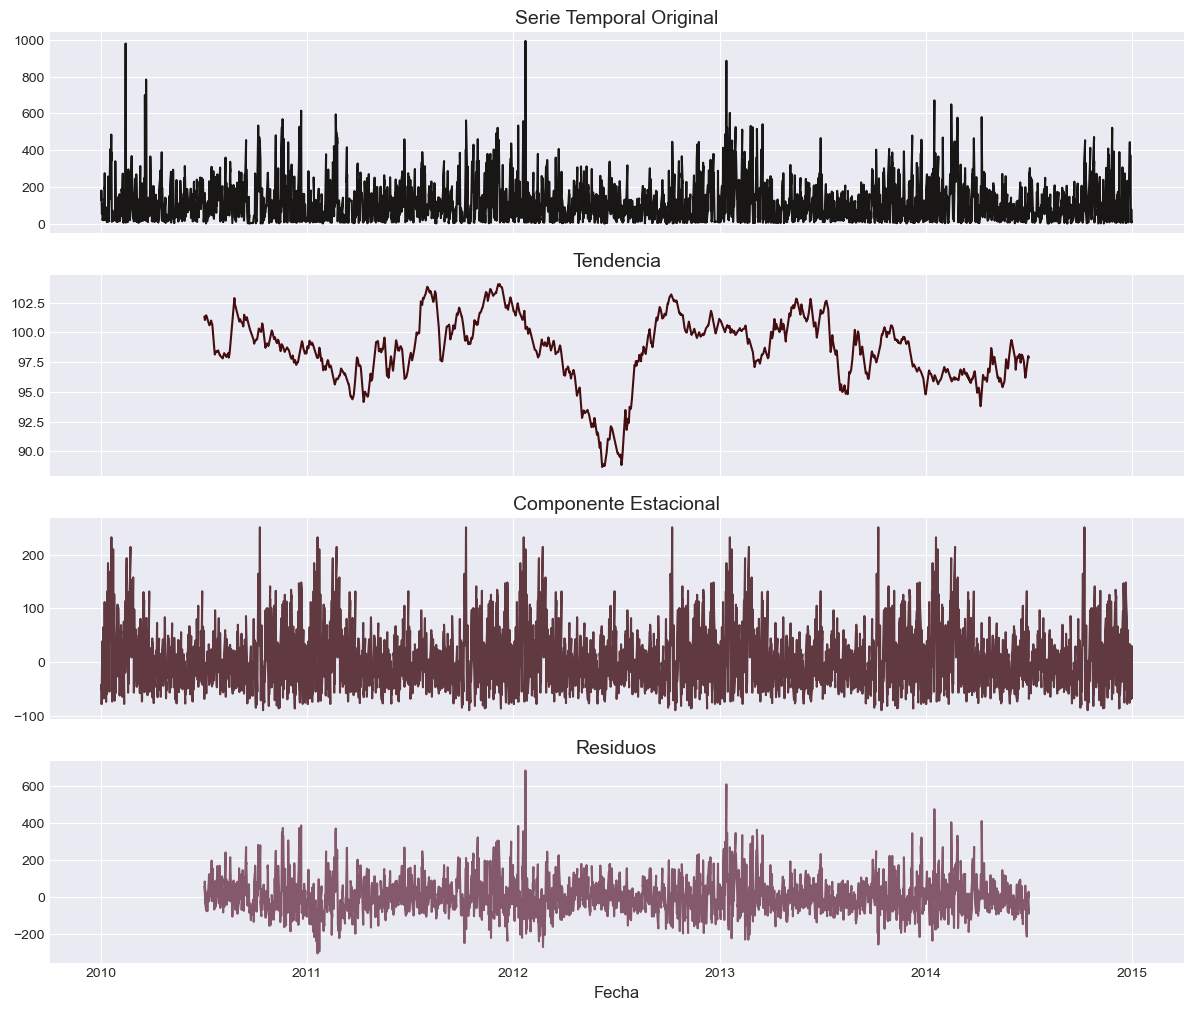

In [87]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Descomposición de la serie temporal
decomposition = seasonal_decompose(df_selected['pm2.5'], model='additive', period=8760)  # period ajusta la frecuencia estacional esperada

# Crear el plot con matplotlib
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(12, 10))

# Plot de la serie original
axes[0].plot(df_selected['pm2.5'], color='#191716')
axes[0].set_title('Serie Temporal Original', fontsize=14)

# Plot de la tendencia
axes[1].plot(decomposition.trend, color='#440D0F')
axes[1].set_title('Tendencia', fontsize=14)

# Plot de la componente estacional
axes[2].plot(decomposition.seasonal, color='#603A40')
axes[2].set_title('Componente Estacional', fontsize=14)

# Plot de los residuos
axes[3].plot(decomposition.resid, color='#84596B')
axes[3].set_title('Residuos', fontsize=14)

# Ajustar el diseño y espaciado
plt.tight_layout()
plt.xlabel('Fecha', fontsize=12)
plt.show()

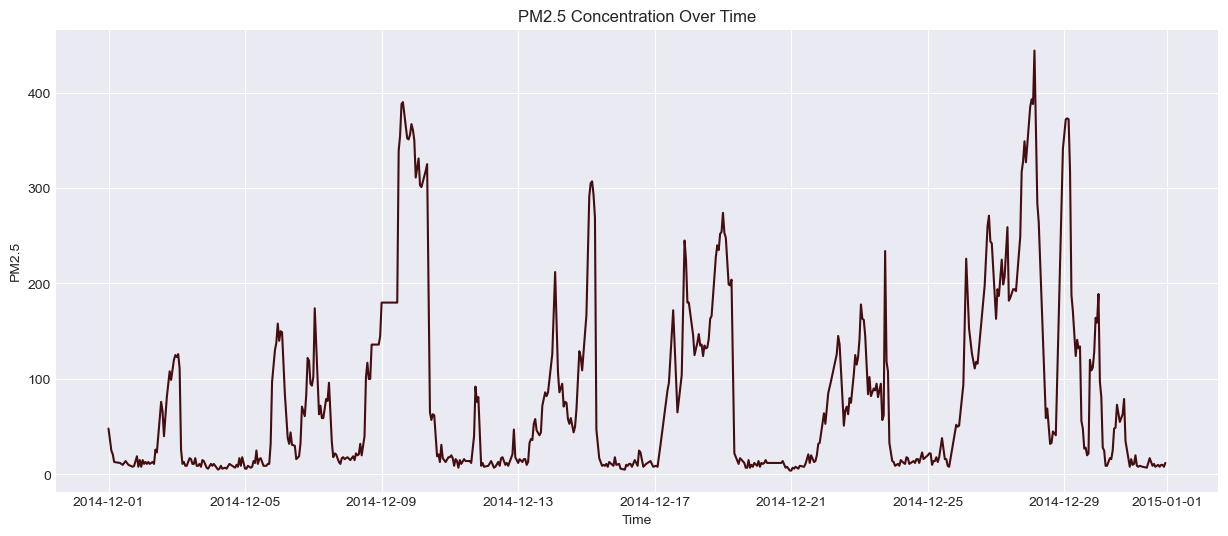

In [88]:
# Graficar la serie temporal
plt.figure(figsize=(15, 6))
plt.plot(df_selected[(df_selected.index.year==2014)&(df_selected.index.month==12)]['pm2.5'], color='#440D0F')
plt.title('PM2.5 Concentration Over 2014')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.show()

Se observa claramente un componente estacional con tendencias en el plot general, que con el 'zoom' anual en 2014 queda completamente asegurado. Si observamos los predictores:


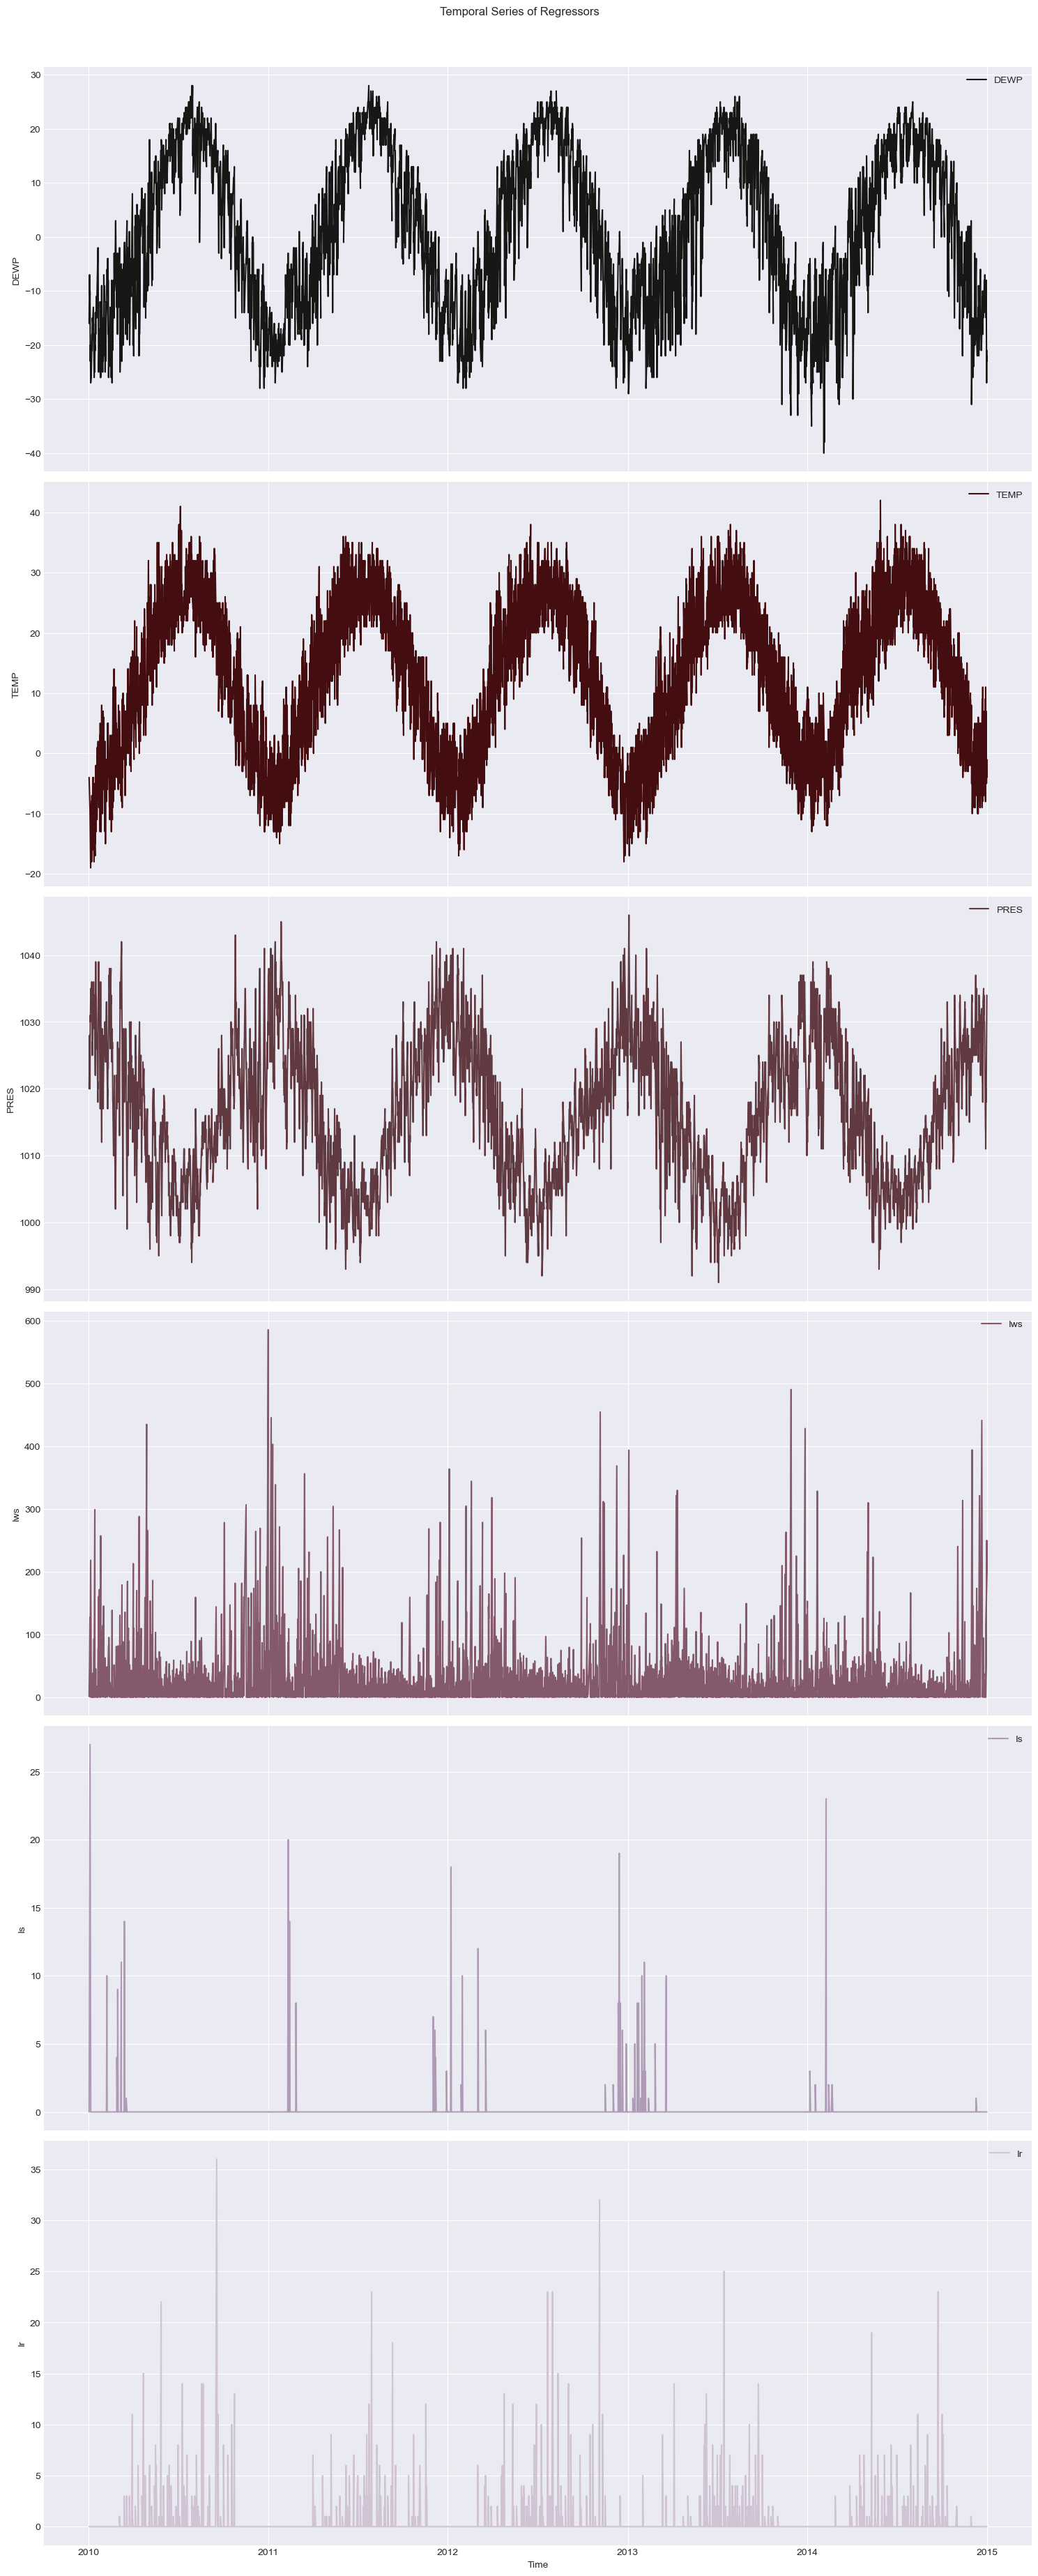

In [90]:
# Lista de regresores
regressors = ['DEWP', 'TEMP','PRES','Iws','Is','Ir']
colors= ['#191716', '#440d0f', '#603a40', '#84596b', '#af9bb6', '#D0C4D4']

# Crear subplots para cada regresor
fig, axs = plt.subplots(figsize=(15, 36), nrows=6, sharex=True)

# Iterar sobre cada regresor y graficar su serie temporal
for i, regressor in enumerate(regressors):
    ax = axs[i]
    ax.plot(df_selected.index, df_selected[regressor], label=regressor, color=colors[i])
    ax.set_ylabel(regressor)
    ax.legend()

# Ajustar el espaciado entre subplots
plt.tight_layout()
plt.xlabel('Time')
plt.suptitle('Temporal Series of Regressors', y=1.02)
plt.show()

Se observa claramente como todos los regresores son estacionales y por tanto, parece muy lógico como la variable respuesta también lo es. 

Podemos, aún así, **extraer la componente estacional de los datos y trabajar así con una serie temporal no estacional**. Esto lo podemos hacer trabajando con la serie temporal `trend` de tendencia (no estacional) que nos ha aportado el `seasonal_decomposition`. Nótese que este análisis de tendencia elimina algunos valores del principio y el final de la serie (normal para el análisis de la media) y los eliminaremos también.

In [72]:
trend = decomposition.trend

trend.dropna()

# Drop rows with NaN/NaT values in the trend component
trend_cleaned = trend.dropna()
print('Number of NA:', trend_cleaned.isna().sum())

trend_cleaned

Number of NA: 0


datetime
2010-07-03 12:00:00    101.327911
2010-07-03 13:00:00    101.315925
2010-07-03 14:00:00    101.301313
2010-07-03 15:00:00    101.284132
2010-07-03 16:00:00    101.268037
                          ...    
2014-07-02 07:00:00     97.879909
2014-07-02 08:00:00     97.878653
2014-07-02 09:00:00     97.877454
2014-07-02 10:00:00     97.876027
2014-07-02 11:00:00     97.874715
Name: trend, Length: 35040, dtype: float64

Ahora podemos realizar un join (en pandas, join es como una join en SQL) con el índice (la fecha) para recuperar los regresores asociados a esos valores de tendencia.

In [73]:
df_merged = trend_cleaned.to_frame(name='trend').join(df_selected.iloc[:,2:], how='inner')
df_merged.head(10)

,trend,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv
datetime,,,,,,,,,
2010-07-03 12:00:00,101.327911,35.0,1000.0,1.79,0,0,0,0,1
2010-07-03 13:00:00,101.315925,36.0,1000.0,3.13,0,0,0,1,0
2010-07-03 14:00:00,101.301313,37.0,999.0,6.26,0,0,0,1,0
2010-07-03 15:00:00,101.284132,37.0,998.0,9.39,0,0,0,1,0
2010-07-03 16:00:00,101.268037,38.0,998.0,13.41,0,0,0,1,0
2010-07-03 17:00:00,101.255936,37.0,998.0,17.43,0,0,0,1,0
2010-07-03 18:00:00,101.245491,37.0,998.0,20.56,0,0,0,1,0
2010-07-03 19:00:00,101.234018,34.0,998.0,22.35,0,0,0,1,0
2010-07-03 20:00:00,101.222146,33.0,998.0,23.24,0,0,0,1,0


Y nuestra **serie temporal no estacional final** es: (35040 entradas de 9 variables)

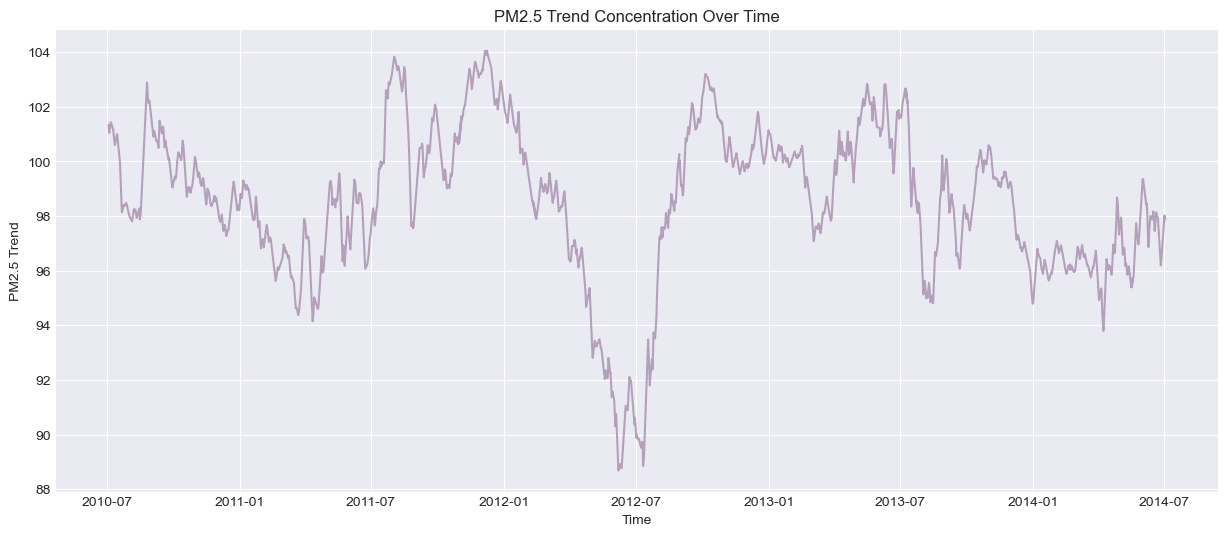

In [91]:
# Graficar la serie temporal
plt.figure(figsize=(15, 6))
plt.plot(df_merged['trend'], color='#B4A0BA')
plt.title('PM2.5 Trend Concentration Over Time')
plt.xlabel('Time')
plt.ylabel('PM2.5 Trend')
plt.show()

# Modelización y predicción

Ahora que ya tenemos una serie temporal que se ajusta a las características de la tarea con una calidad asegurada, podemos plantear la pregunta de predecir 100 instantes en el futuro. 

## Modelo VAR

EL modelo de vectores autoregresivos [VAR](https://en.wikipedia.org/wiki/Vector_autoregression) es la generalización del modelo autoregressivo clásico univariante AR para series temporales multivariantes. Es uno de los modelos mas sencillo que se pueden realizar aunque sus resultados a menudo son muy satisfactorios. El modelo depende del 'lag' o cantidad de pasos atrás que realiza la autoregresión. Entrenamos el modelo con  un número maximo de lags elevado para que la funcion de `statsmodels` elija el más adecuado.

Vamos a realizar la predicción sobre los últimos 100 instantes de la serie (con la función `forecast`que no usa los regresores), así podremos calcular luego el MSE con respecto a los valores reales y comparar con algún futuro modelo.

Train shape: (34940, 9)
Test shape: (100, 9)


C:\Users\marco\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


Mean Squared Error: 35.30585494829081
Lags utilizados:  54


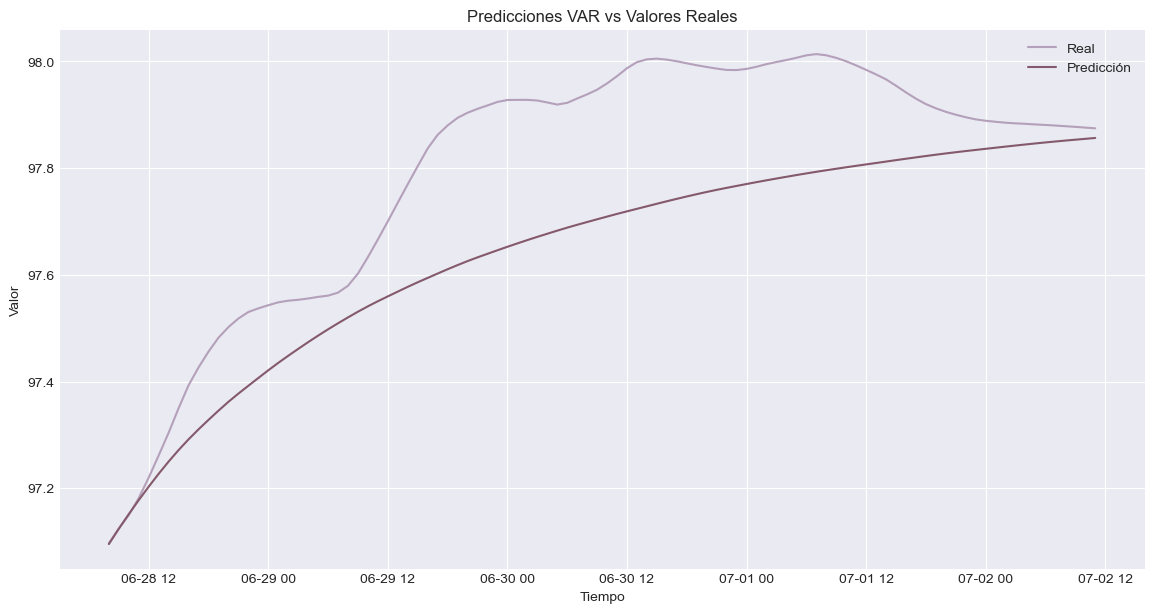

In [92]:
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

# Obetener total de datos
len = df_merged.shape[0]

# Filtrar los datos para los 10 primeros meses y los dos últimos meses de 2010
train = df_merged.iloc[:len-100,]
forecast_real = df_merged.iloc[len-100:,]

# Verificar que la división fue correcta
print("Train shape:", train.shape)
print("Test shape:", forecast_real.shape)

# Entrenar el modelo VAR
model = VAR(train)
model_fit = model.fit(maxlags=150, ic='aic')

# Hacer predicciones
lag_order = model_fit.k_ar
predicted_values = model_fit.forecast(train.values[-lag_order:], steps=100)
# Convertir las predicciones a un DataFrame
predicted_df = pd.DataFrame(predicted_values, index=forecast_real.index, columns=forecast_real.columns)

# Calcular el error cuadrático medio
mse = mean_squared_error(forecast_real.values, predicted_df.values)
print("Mean Squared Error:", mse)
print('Lags utilizados: ', lag_order)

# Visualizar resultados
plt.figure(figsize=(14, 7))
plt.plot(forecast_real.index, forecast_real['trend'], label='Real', color='#B4A0BA')
plt.plot(forecast_real.index, predicted_df['trend'], label='Predicción', color='#84596B')
plt.title('Predicciones VAR vs Valores Reales')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.legend()
plt.show()
